**Import Library**

In [283]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as im
import sympy as sp
from PIL import Image, ImageOps
import os

**Size of Data**

In [309]:
#Size of the image
Face = Image.open("archive\\s1\\1.pgm") 
FaceArray = im.pil_to_array(Face)
Height, Width = FaceArray.shape
#Number of classes
num_class = sum(1 for entry in os.scandir("archive") if not entry.is_file())
#Number of files in a class
num_files = sum(1 for entry in os.scandir("archive\\s1") if entry.is_file())
#Total number of files
num_total = num_files*num_class

**Function**

In [310]:
#Process the Image into a flat 1D array
def ProcessImage(img):
    Grayscale = img.convert('L')
    Facematrix = im.pil_to_array(Grayscale)
    FlatFaceArray = np.concat(Facematrix,axis=None)/255

    return FlatFaceArray

#Make the Data Matrix
def Datamatrix(clsdir: str, num_files: int):
    for i in range(num_files):
        imgdir = clsdir +"\\" + str(i+1) + ".pgm"
    #Import image
        Face = Image.open(imgdir)
        FlatFaceArray = ProcessImage(Face)
    #Combine each 1D array in to a matrix
        if i == 0:
            FaceMatrix = FlatFaceArray
        else:
            FaceMatrix = np.column_stack((FaceMatrix,FlatFaceArray))
    return FaceMatrix

#Make a Data Matrix for a class k
def ClassMatrix(k: int):
    clsdir = "archive\\s" + str(k)
    return Datamatrix(clsdir, num_files)
ClassMatrix(2).shape

#More efficent way to calculate the svd of the datamatrix
def svd(X):
    XtX = X.T @ X
    V, S, Vt = np.linalg.svd(XtX)
    S_matrix = np.sqrt(np.diag(S))
    S_inv = np.linalg.inv(S_matrix)
    U = X @ V @ S_inv
    return U, np.sqrt(S), Vt

**Make the overall Data Matrix**

In [311]:

for i in range(num_class):
    if i == 0:
        FullMatrix = ClassMatrix(i+1)
    else:
        FullMatrix = np.append(FullMatrix, ClassMatrix(i+1),axis=1)
FullMatrix.shape

(10304, 400)

In [312]:
#The average face
MeanFace=np.mean(FullMatrix, axis=1)
ColumnMeanFace= MeanFace[:, np.newaxis]
print(MeanFace)


[0.3357549  0.33559804 0.33696078 ... 0.30145098 0.2975098  0.2950098 ]


**Calculate the eigenvalues and eigenfaces**

In [313]:
#Minus the mean
CenteredFullMatrix=FullMatrix  - ColumnMeanFace
#Find the Eigenface of the Data
U, S, Vt = svd(CenteredFullMatrix)
#Find the needed amount of eigenvalues
eigsum=np.sum(S)
csum=0
for i in range(S.shape[0]):
    csum +=S[i]
    if csum > 0.9*eigsum:
        e90=i
        break

#S_matrix = np.zeros(np.diag(S).shape)
#S_matrix[:e90, :e90] = np.sqrt(np.diag(S_reduced))
#Reducing the eigenvalues and vector to the needed amount
U_reduced = U[:,:e90]
S_reduced= np.sqrt(np.diag(S[0:e90]))
e90


297

In [314]:
#Projecting a vector in to the facespace
def Facespace(vector):
    return U_reduced.T @ vector

#the average of a class k in facespace
def avgClassOmega(k: int):
    S = 0
    for i in range(num_files):
        S+= Facespace(ClassMatrix(k)[:,i])
    print(S)
    return S/len(range(num_files))

#Find the threshold for the picture to be indentified as a face in class k
def Classepsilon(k: int):
    Cepsilon = 0
    for i in range(num_files):
        e=np.linalg.norm(Facespace(ClassMatrix(k)[:,i])-avgClassOmega(k))
        if e > Cepsilon:
            Cepsilon = e
    return Cepsilon*1.2

#np.linalg.norm(avgClassOmega(34)), np.linalg.norm(Facespace(ClassMatrix(1)[:,1])-avgClassOmega(34))
Facespace(CenteredFullMatrix[:,1]).shape

(297,)

In [315]:

#The average of all the data in facespace
#S = 0
#for i in range(num_total):
#    S = S+ Facespace(CenteredFullMatrix[:,i])
#avgOmega = S#/len(range(num_files))
#Find the threshold for the picture to be identified as a face, let that be epsilon
epsilon=0
#Array of a facevector after being transform in facespace
def Ffacearray(facearray):
    return Facespace(facearray) @ U_reduced.T
for i in range(num_total):
    facearray = CenteredFullMatrix[:,i]
    e = np.linalg.norm(facearray-Ffacearray(facearray))
    if e > epsilon:
        epsilon = e
#Let the threshold be 2epsilon
epsilon = 4*epsilon
epsilon
#Facespace(ClassMatrix(2)[:,1]).shape

np.float64(11.767476313988528)

**Face recognization**

In [316]:

#Input = ProcessImage(Image.open("32.JPG"))-MeanFace
#Input.shape
#Let the image that need to be specify is input
def Classify(imgdir: str ):
    image=Image.open(imgdir)
    facearray = ProcessImage(image)-MeanFace
    dist = np.linalg.norm(facearray - Ffacearray(facearray))
    if epsilon > dist:
        print("this image contains a face")
    else: 
        print("this image does not contain a face")
    print(dist)



In [317]:
Height, Width

(112, 92)

In [318]:
Classify("input.JPG")
#troll

this image contains a face
10.07467330921246


# Fisher face

In [319]:
#SVD ma trận data ban đầu
U, S, V = svd(CenteredFullMatrix)

**Ta lấy PCA ma trận về N-c chiều**

In [320]:
#Lấy số chiều cần cho LDA
U_reduced = U[:,:num_total - num_class]
#Chuyển toàn bộ ma trận data về Facespace này
FacespaceMatrix = U_reduced.T @ FullMatrix
FacespaceMatrix.shape
#
ColumnMeanFace = np.mean(FullMatrix,axis=1)[:, np.newaxis]

Tìm Sb và Sw trong Facespace

In [321]:
def FaceClassMatrix(k: int):
    return FacespaceMatrix[:,num_files*(k-1):num_files*k]
FaceClassMatrix(1).shape


(360, 10)

In [ ]:
#Mean của một class
def MeanClassFace(k: int):
    MeanFace=np.mean(ClassMatrix(k), axis=1)
    return MeanFace[:, np.newaxis]
#Tìm Sb
for i in range(num_class):
    if i == 0:
        Xb = MeanClassFace(i+1) - ColumnMeanFace
    else:
        Xb = np.column_stack((Xb,MeanClassFace(i+1)-ColumnMeanFace))
Xb2 = U_reduced.T @ Xb
Sb = num_files * Xb2 @ Xb2.T
Sb.shape

np.int64(39)

In [ ]:
for i in range(num_class):
    if i == 0:
        Xw = ClassMatrix(i+1) - MeanClassFace(i+1)
        Xw2 = U_reduced.T @ Xw
        Sw = Xw2 @ Xw2.T
    else:
        Xw = ClassMatrix(i+1) - MeanClassFace(i+1)
        Xw2 = U_reduced.T @ Xw
        Sw += Xw2 @ Xw2.T
Sw.shape

np.int64(360)

In [328]:
#LDA
U, S, Vt = np.linalg.svd(np.linalg.inv(Sw) @ Sb)
#Giảm các ma trận về số chiều cần dùng (rank của Sb)
dim = np.linalg.matrix_rank(Sb)
U_ff= U[:, dim] 
S_ff= np.diag(S[0:dim])

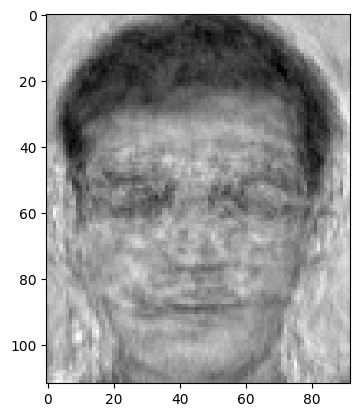

In [ ]:
plt.figure()
img = ProcessImage(Image.open("18.JPG"))
#img = CenteredFullMatrix[:,3]
plt.imshow(img.reshape((Height, Width)), cmap=plt.cm.gray)
plt.imshow(Ffacearray(img).reshape((Height, Width)),cmap=plt.cm.gray)
#ProcessImage(Image.open("input.JPG"))


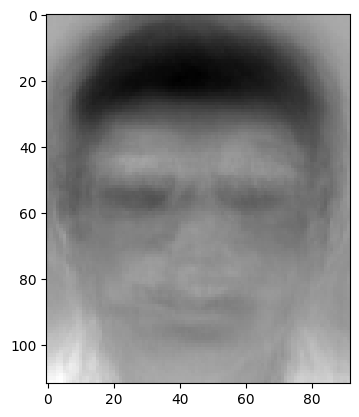

In [ ]:
plt.imshow(U[:,0].reshape((Height,Width)),cmap=plt.cm.gray)

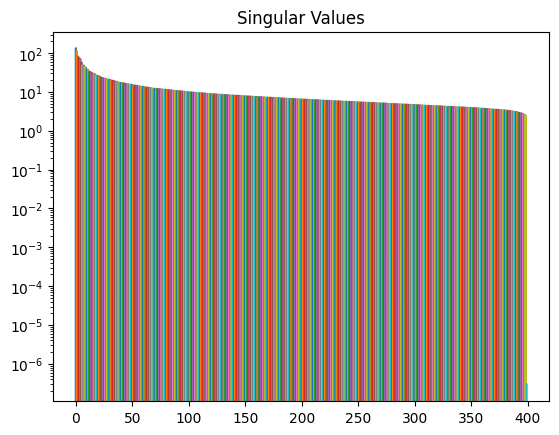

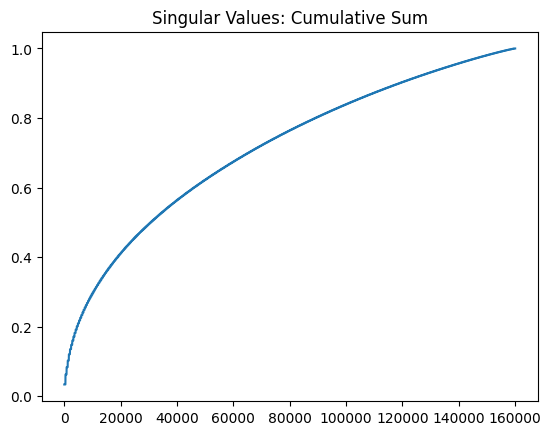

In [ ]:
def plot_cumulative_sum(Sr):
    plt.clf
    plt.figure(1)
    plt.semilogy(np.diag(Sr))
    plt.title('Singular Values')
    plt.show()

    plt.figure(1)
    plt.plot(np.cumsum(np.diag(Sr))/np.sum(np.diag(Sr)))
    plt.title('Singular Values: Cumulative Sum')
    plt.show()
plot_cumulative_sum(S)

In [ ]:
S

array([1.31635097e+02, 1.12694860e+02, 8.20462459e+01, 7.40923770e+01,
       7.09094818e+01, 5.75215914e+01, 4.90718030e+01, 4.78932936e+01,
       4.39409506e+01, 4.21181224e+01, 3.76284573e+01, 3.70884865e+01,
       3.31833661e+01, 3.24067559e+01, 3.09685794e+01, 2.99834540e+01,
       2.93602686e+01, 2.88260511e+01, 2.69020978e+01, 2.61580114e+01,
       2.56945811e+01, 2.50657855e+01, 2.41575328e+01, 2.31321409e+01,
       2.28172297e+01, 2.20383731e+01, 2.17630593e+01, 2.17076883e+01,
       2.09966159e+01, 2.07162230e+01, 2.05477594e+01, 1.98186761e+01,
       1.97025172e+01, 1.93448664e+01, 1.90689206e+01, 1.85678272e+01,
       1.82909065e+01, 1.81945866e+01, 1.76720468e+01, 1.71881793e+01,
       1.70477939e+01, 1.69134554e+01, 1.66511708e+01, 1.65274243e+01,
       1.62371683e+01, 1.59555606e+01, 1.58174828e+01, 1.56503323e+01,
       1.55194075e+01, 1.53660474e+01, 1.52221615e+01, 1.47034455e+01,
       1.46035709e+01, 1.44961218e+01, 1.44591169e+01, 1.42159764e+01,
      